In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

# BTC

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv')
df1=df.reset_index()['Close']
df1

0         998.325012
1        1021.750000
2        1043.839966
3        1154.729980
4        1013.380005
            ...     
2347    27238.783203
2348    26345.998047
2349    26508.216797
2350    26480.375000
2351    25851.240234
Name: Close, Length: 2352, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 18s 186ms/step - loss: 0.0296 - val_loss: 0.0129
Epoch 2/100
25/25 [==============================] - 5s 193ms/step - loss: 0.0046 - val_loss: 0.0097
Epoch 3/100
25/25 [==============================] - 5s 193ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 4/100
25/25 [==============================] - 4s 165ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/100
25/25 [==============================] - 6s 233ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 6/100
25/25 [==============================] - 4s 168ms/step - loss: 9.3582e-04 - val_loss: 0.0029
Epoch 7/100
25/25 [==============================] - 4s 164ms/step - loss: 8.8416e-04 - val_loss: 0.0030
Epoch 8/100
25/25 [==============================] - 6s 243ms/step - loss: 8.9221e-04 - val_loss: 0.0030
Epoch 9/100
25/25 [==============================] - 4s 166ms/step - loss: 8.5445e-04 - val_loss: 0.0024
Epoch 10/100
25/25 [==============================] - 6s 228ms/step - loss

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 24ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
test_data.shape

(470, 1)

In [ ]:
y_pred.shape

(369, 1)

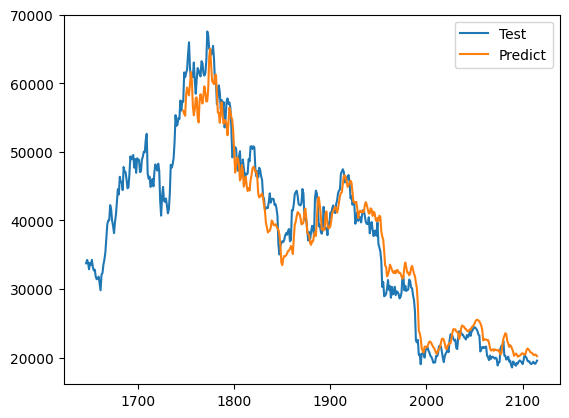

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

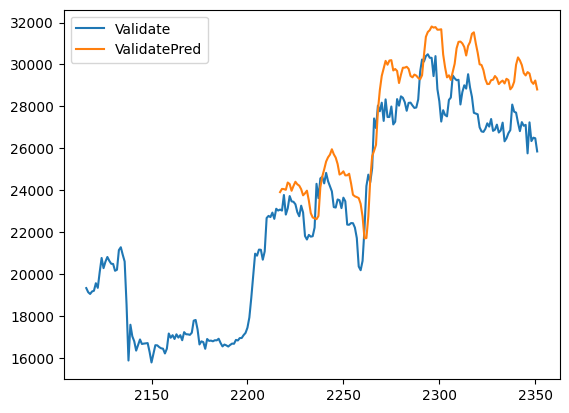

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation MAE: 27777.4723234541
Testing MAE: 36358.99481420617
Validation MSE: 780291616.9505551
Testing MSE: 1472492107.789468
Validation RMSE: 27933.700380553862
Testing RMSE: 38373.06487354728


In [ ]:
val_data.shape

(236, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[135:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.33984167472285126, 0.32318045918341626, 0.3230407645002817, 0.32427096670461614, 0.3241847870455838, 0.32104073551480466, 0.3135291854240855, 0.2932405577891798, 0.29060872984428837, 0.2972739822314457, 0.32020496535696785, 0.3506528208324368, 0.35886585638663354, 0.3533243317760751, 0.36345814729098547, 0.3989600727667616, 0.3921019031041932, 0.4081643644805173, 0.40410023469655343, 0.4102177037878186, 0.3972158923855853, 0.4125856997395678, 0.39999849817980515, 0.40001978721671577, 0.4075003980202764, 0.39470726596885924, 0.39662737333637377, 0.4128023332360428, 0.4080878058285503, 0.4147494028178864, 0.4137395187510307, 0.4105694407877647, 0.40444436846903153, 0.41010201775757354, 0.41025016372047074, 0.4082461869053468, 0.4064752197689368, 0.40680364995237506, 0.412571896957395, 0.43233455671060533, 0.4410497269527033, 0.43961227831349864, 0.44350533547943083, 0.44480244608548436, 0.4422989957120731, 0.4422519726745013, 0.4292212397647068, 0.44348267201293945, 0.4199028

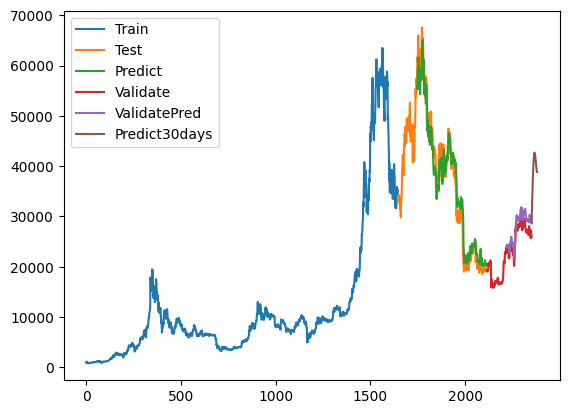

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 263ms/step - loss: 0.0043 - val_loss: 0.1546
Epoch 2/100
17/17 [==============================] - 3s 188ms/step - loss: 0.0013 - val_loss: 0.0830
Epoch 3/100
17/17 [==============================] - 3s 177ms/step - loss: 5.0095e-04 - val_loss: 0.0126
Epoch 4/100
17/17 [==============================] - 4s 224ms/step - loss: 2.9294e-04 - val_loss: 0.0114
Epoch 5/100
17/17 [==============================] - 4s 212ms/step - loss: 2.8728e-04 - val_loss: 0.0294
Epoch 6/100
17/17 [==============================] - 4s 265ms/step - loss: 2.1548e-04 - val_loss: 0.0225
Epoch 7/100
17/17 [==============================] - 3s 175ms/step - loss: 1.9499e-04 - val_loss: 0.0236
Epoch 8/100
17/17 [==============================] - 5s 290ms/step - loss: 1.8247e-04 - val_loss: 0.0317
Epoch 9/100
17/17 [==============================] - 3s 175ms/step - loss: 1.7286e-04 - val_loss: 0.0313
Epoch 10/100
17/17 [==============================] - 3s 167ms/

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

12/12 [==============================] - 0s 18ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

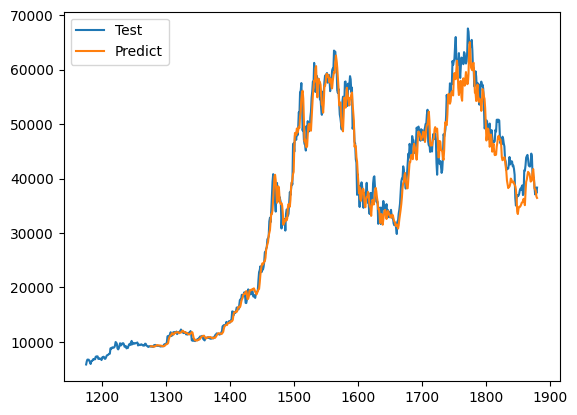

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1 + test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start = train_size1 + 101, stop = train_size1 + test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

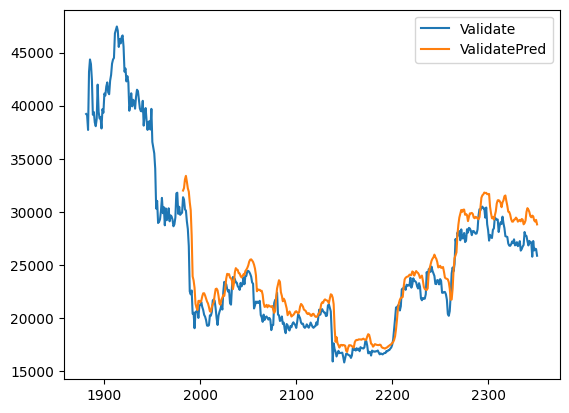

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)

Validation MAE: 23617.31953666358
Testing MAE: 35832.62596486183
Validation MSE: 577427943.8321159
Testing MSE: 1562295426.2416174
Validation RMSE: 24029.73041530254
Testing RMSE: 39525.88299129593


In [ ]:
val_data1.shape

(471, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[370:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

(1, 101)
[0.33984167472285126, 0.32318045918341626, 0.3230407645002817, 0.32427096670461614, 0.3241847870455838, 0.32104073551480466, 0.3135291854240855, 0.2932405577891798, 0.29060872984428837, 0.2972739822314457, 0.32020496535696785, 0.3506528208324368, 0.35886585638663354, 0.3533243317760751, 0.36345814729098547, 0.3989600727667616, 0.3921019031041932, 0.4081643644805173, 0.40410023469655343, 0.4102177037878186, 0.3972158923855853, 0.4125856997395678, 0.39999849817980515, 0.40001978721671577, 0.4075003980202764, 0.39470726596885924, 0.39662737333637377, 0.4128023332360428, 0.4080878058285503, 0.4147494028178864, 0.4137395187510307, 0.4105694407877647, 0.40444436846903153, 0.41010201775757354, 0.41025016372047074, 0.4082461869053468, 0.4064752197689368, 0.40680364995237506, 0.412571896957395, 0.43233455671060533, 0.4410497269527033, 0.43961227831349864, 0.44350533547943083, 0.44480244608548436, 0.4422989957120731, 0.4422519726745013, 0.4292212397647068, 0.44348267201293945, 0.4199028

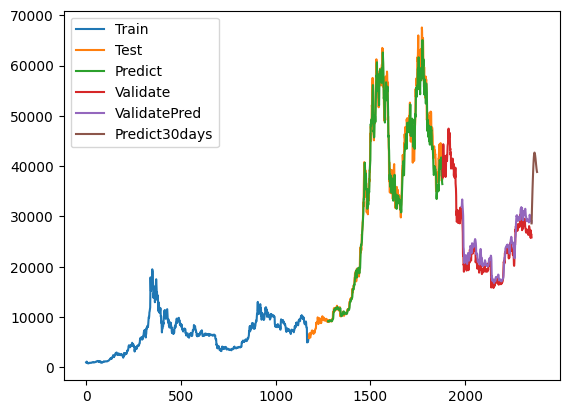

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# DOGE

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.001415
1       0.001163
2       0.001201
3       0.001038
4       0.001211
          ...   
2035    0.070373
2036    0.067300
2037    0.067966
2038    0.069489
2039    0.061860
Name: Close, Length: 2040, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 22s 360ms/step - loss: 0.0106 - val_loss: 8.5382e-04
Epoch 2/100
21/21 [==============================] - 4s 197ms/step - loss: 0.0028 - val_loss: 4.5801e-04
Epoch 3/100
21/21 [==============================] - 5s 254ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4/100
21/21 [==============================] - 6s 252ms/step - loss: 0.0018 - val_loss: 5.0368e-04
Epoch 5/100
21/21 [==============================] - 4s 206ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/100
21/21 [==============================] - 6s 289ms/step - loss: 0.0014 - val_loss: 7.6424e-04
Epoch 7/100
21/21 [==============================] - 5s 228ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 8/100
21/21 [==============================] - 5s 233ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 9/100
21/21 [==============================] - 7s 346ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/100
21/21 [==============================] - 4s 201ms/step - loss

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 31ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
test_data.shape

(408, 1)

In [ ]:
y_pred.shape

(307, 1)

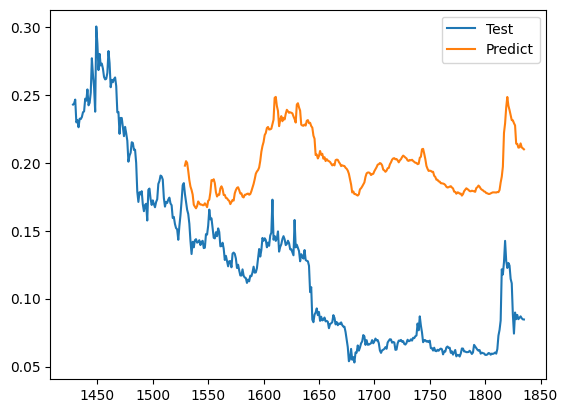

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

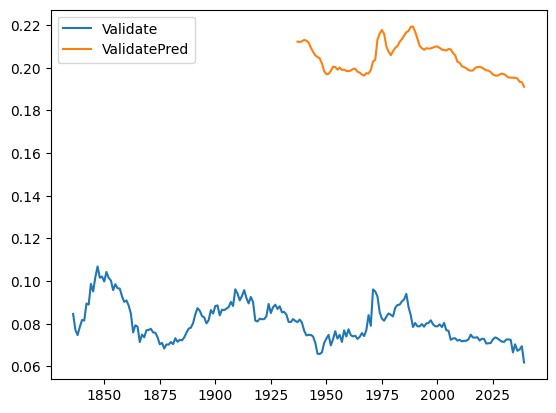

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation MAE: 0.09312971270072787
Testing MAE: 0.06683068453400497
Validation MSE: 0.00881251516513707
Testing MSE: 0.006279754552845548
Validation RMSE: 0.09387499755066346
Testing RMSE: 0.07924490237766432


In [ ]:
val_data.shape

(204, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[103:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

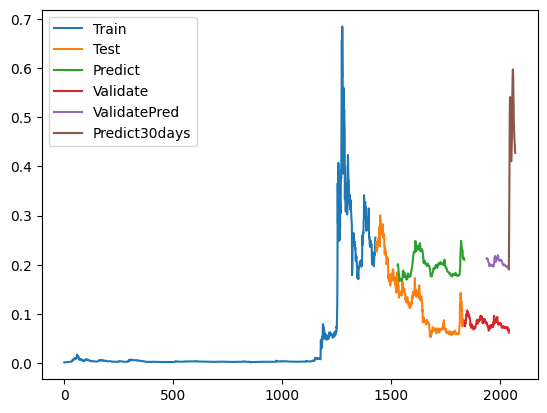

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 10s 375ms/step - loss: 8.0062e-06 - val_loss: 0.0880
Epoch 2/100
15/15 [==============================] - 3s 201ms/step - loss: 3.3839e-06 - val_loss: 0.0875
Epoch 3/100
15/15 [==============================] - 3s 199ms/step - loss: 2.6975e-06 - val_loss: 0.0874
Epoch 4/100
15/15 [==============================] - 4s 261ms/step - loss: 2.4747e-06 - val_loss: 0.0873
Epoch 5/100
15/15 [==============================] - 5s 300ms/step - loss: 2.2849e-06 - val_loss: 0.0870
Epoch 6/100
15/15 [==============================] - 3s 212ms/step - loss: 2.3429e-06 - val_loss: 0.0862
Epoch 7/100
15/15 [==============================] - 3s 207ms/step - loss: 2.3066e-06 - val_loss: 0.0860
Epoch 8/100
15/15 [==============================] - 4s 262ms/step - loss: 2.2700e-06 - val_loss: 0.0854
Epoch 9/100
15/15 [==============================] - 4s 283ms/step - loss: 2.2370e-06 - val_loss: 0.0846
Epoch 10/100
15/15 [==============================] - 

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 19ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

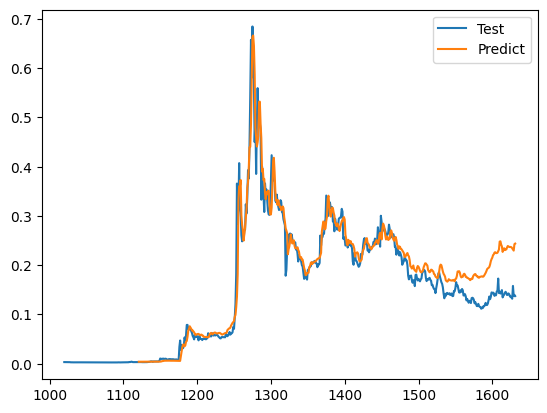

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

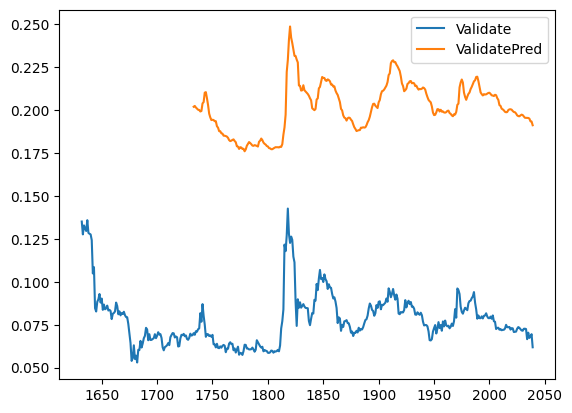

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)

Validation MAE: 0.08922523560959532
Testing MAE: 0.1696063639140394
Validation MSE: 0.008557895831932935
Testing MSE: 0.047989351689941756
Validation RMSE: 0.09250889596105304
Testing RMSE: 0.2190647203224238


In [ ]:
val_data1.shape

(408, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[307:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

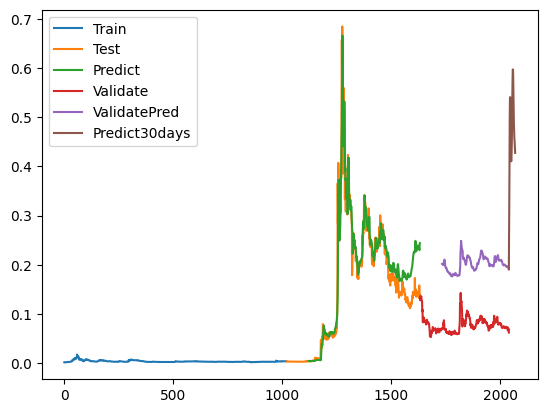

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

# ETH

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv')
df1=df.reset_index()['Close']
df1

0       0.001415
1       0.001163
2       0.001201
3       0.001038
4       0.001211
          ...   
2035    0.070373
2036    0.067300
2037    0.067966
2038    0.069489
2039    0.061860
Name: Close, Length: 2040, dtype: float64

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## 7:3:1

In [ ]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 17s 191ms/step - loss: 0.0104 - val_loss: 0.0012
Epoch 2/100
21/21 [==============================] - 4s 174ms/step - loss: 0.0030 - val_loss: 6.7791e-04
Epoch 3/100
21/21 [==============================] - 5s 235ms/step - loss: 0.0022 - val_loss: 4.0876e-04
Epoch 4/100
21/21 [==============================] - 4s 177ms/step - loss: 0.0016 - val_loss: 7.1629e-04
Epoch 5/100
21/21 [==============================] - 3s 166ms/step - loss: 0.0014 - val_loss: 5.1578e-04
Epoch 6/100
21/21 [==============================] - 3s 163ms/step - loss: 0.0015 - val_loss: 8.0465e-04
Epoch 7/100
21/21 [==============================] - 5s 259ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/100
21/21 [==============================] - 3s 166ms/step - loss: 0.0013 - val_loss: 9.1142e-04
Epoch 9/100
21/21 [==============================] - 4s 178ms/step - loss: 0.0012 - val_loss: 5.9744e-04
Epoch 10/100
21/21 [==============================] - 6s 276ms

In [ ]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 26ms/step


In [ ]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [ ]:
test_data.shape

(408, 1)

In [ ]:
y_pred.shape

(307, 1)

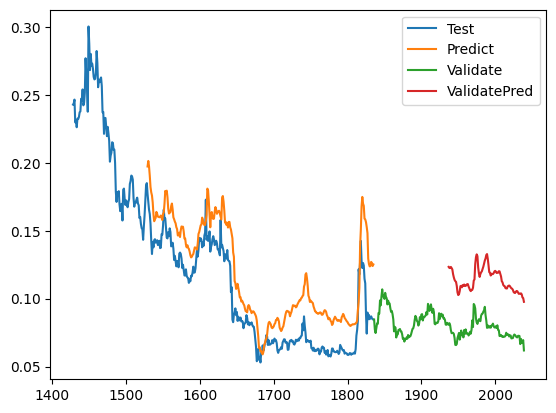

In [ ]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(y_pred_val))

plt.legend(['Test','Predict','Validate','ValidatePred'])
plt.show()

In [ ]:
val_data.shape

(204, 1)

In [ ]:
y_pred_val.shape

(103, 1)

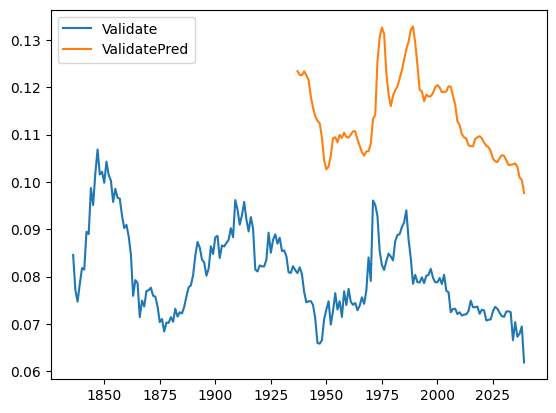

In [ ]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,(y_pred_val))

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))

print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

valid_mse = np.mean((y_pred_val - yval)**2)
test_mse = np.mean((y_pred - ytest)**2)

print('Validation MSE:', valid_mse)
print('Testing MSE:', test_mse)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation MAE: 0.010272799935579177
Testing MAE: 0.052741128843709066
Validation MSE: 0.00016739102171059163
Testing MSE: 0.004378848052356707
Validation RMSE: 0.012937968221888306
Testing RMSE: 0.06617286492480666


ValueError: ignored

In [ ]:
val_data.shape

(204, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[103:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

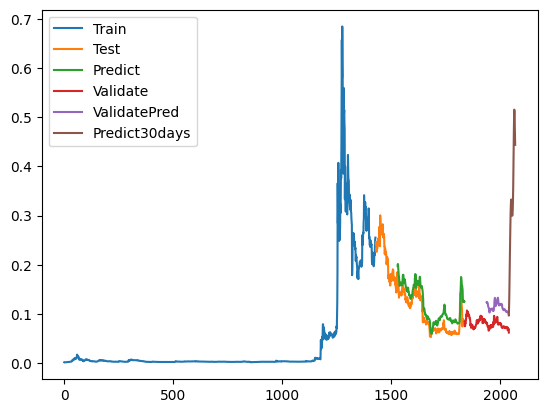

In [ ]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

## 5:3:2

In [ ]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [ ]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [ ]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1] , 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1] , 1)

In [ ]:
# Define the model
model1 = Sequential()

# Add a 1D convolutional layer
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model1.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 8s 219ms/step - loss: 4.5058e-06 - val_loss: 0.0886
Epoch 2/100
15/15 [==============================] - 3s 204ms/step - loss: 2.4980e-06 - val_loss: 0.0880
Epoch 3/100
15/15 [==============================] - 4s 268ms/step - loss: 2.3125e-06 - val_loss: 0.0872
Epoch 4/100
15/15 [==============================] - 3s 210ms/step - loss: 2.4557e-06 - val_loss: 0.0866
Epoch 5/100
15/15 [==============================] - 3s 171ms/step - loss: 2.3416e-06 - val_loss: 0.0863
Epoch 6/100
15/15 [==============================] - 3s 185ms/step - loss: 2.4820e-06 - val_loss: 0.0856
Epoch 7/100
15/15 [==============================] - 3s 170ms/step - loss: 2.6604e-06 - val_loss: 0.0836
Epoch 8/100
15/15 [==============================] - 5s 312ms/step - loss: 2.4114e-06 - val_loss: 0.0831
Epoch 9/100
15/15 [==============================] - 3s 182ms/step - loss: 2.2278e-06 - val_loss: 0.0815
Epoch 10/100
15/15 [==============================] - 3

In [ ]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 15ms/step


In [ ]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

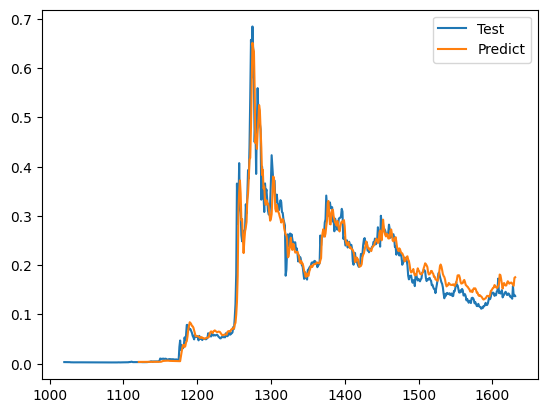

In [ ]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

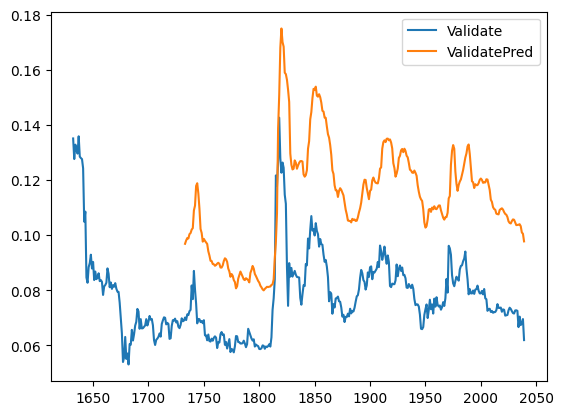

In [ ]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','ValidatePred'])
plt.show()

In [ ]:
valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
test_mae1 = np.mean(np.abs(y_pred1 - ytest1))

print('Validation MAE:', valid_mae1)
print('Testing MAE:', test_mae1)

valid_mse1 = np.mean((y_pred_val1 - yval1)**2)
test_mse1 = np.mean((y_pred1 - ytest1)**2)

print('Validation MSE:', valid_mse1)
print('Testing MSE:', test_mse1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))

print('Validation RMSE:', valid_rmse1)
print('Testing RMSE:', test_rmse1)

Validation MAE: 0.021676535000167557
Testing MAE: 0.17195154195173026
Validation MSE: 0.0007777350480659777
Testing MSE: 0.048985973144995844
Validation RMSE: 0.027887901464003665
Testing RMSE: 0.22132775050814538


In [ ]:
val_data1.shape

(408, 1)

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input1=val_data1[307:].reshape(1,-1)
print(x_input1.shape)

temp_input1=list(x_input1)
temp_input1=temp_input1[0].tolist()
print(temp_input1)
from numpy import array

lst_output1=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input1)>100):
        x_input1 = np.array(temp_input1[1:])
        print("{} day input {}".format(i,x_input1))
        x_input1 = x_input1.reshape(1,-1)
        x_input1 = x_input1.reshape((1, n_steps, 1))

        yhat1 = model.predict(x_input1, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input1.extend(yhat1[0].tolist())
        temp_input1 = temp_input1[1:]

        lst_output1.extend(yhat1.tolist())
        i=i+1
    else:
        x_input1 = x_input1.reshape((1, n_steps,1))
        yhat1 = model1.predict(x_input1, verbose=0)
        print(yhat1[0])
        temp_input1.extend1(yhat1[0].tolist())
        print(len(temp_input1))
        lst_output1.extend(yhat1.tolist())
        i=i+1

(1, 101)
[0.11624610283428666, 0.1107718023180106, 0.10752348226430411, 0.10787303043531762, 0.10788765396688135, 0.10678050443076667, 0.10251279782396615, 0.09499091957146999, 0.09476569321238641, 0.09587868344367119, 0.10232413029379199, 0.10530772301828205, 0.10786132725133893, 0.10066414152492571, 0.10483532410595031, 0.1103798328292792, 0.10532088637605326, 0.10789935715086008, 0.10303492981979773, 0.11094291507221679, 0.10670884694674065, 0.11170051643731797, 0.10770483802869649, 0.10677465283877724, 0.10732019120256622, 0.10509418894635798, 0.10645143138330616, 0.10908986735497947, 0.10706862723112098, 0.11114913737835908, 0.12141035614968203, 0.11415320522640217, 0.1390018652957422, 0.13765632604277273, 0.13423104164287078, 0.12340088903662065, 0.11907759775433117, 0.11754045972678313, 0.12029736591839726, 0.12258186230086028, 0.1216823952446804, 0.12050650857212457, 0.12643128360020617, 0.128334053504124, 0.12861047312049975, 0.1308013658247719, 0.13223027664256531, 0.13594514

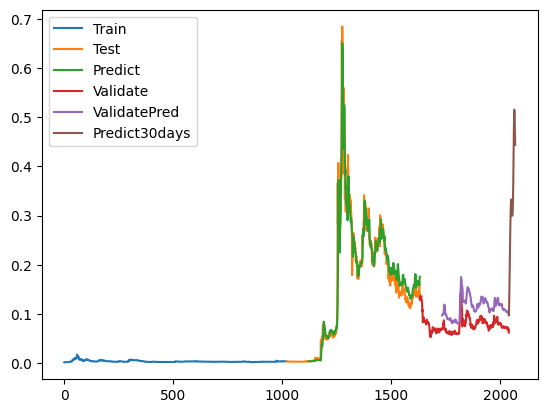

In [ ]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

prediect_data_index1 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index1,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()